This notebook demonstrates the Sine_Task and Sine_Task_Distribution classes by training a simple model to fit a sampled sine wave.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from src.tasks import Sine_Task_Distribution

In [2]:
tasks = Sine_Task_Distribution(0.1, 5, 0, np.pi, -5, 5)

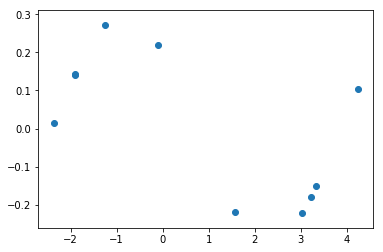

In [18]:
sine = tasks.sample_task()
plt.scatter(*sine.sample_data(10))
plt.show()

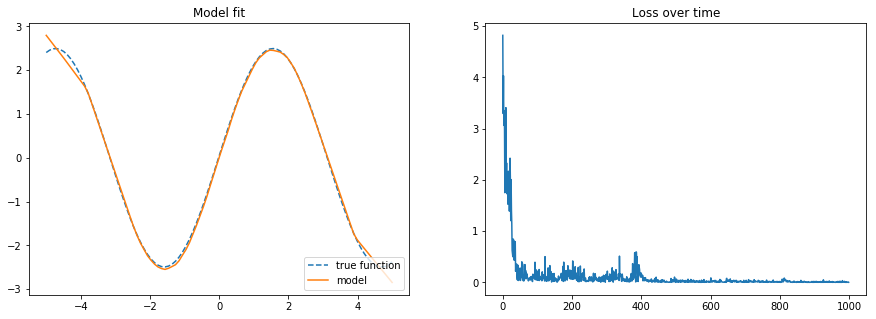

In [6]:
# set up model and task
model = nn.Sequential(
    nn.Linear(1,40),
    nn.ReLU(),
    nn.Linear(40,40),
    nn.ReLU(),
    nn.Linear(40,1)
)
task = tasks.sample_task()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# fit the model
losses = []

for i in range(1000):
    model.zero_grad()
    x, y = task.sample_data(10)
    y_hat = model(x)
    loss = criterion(y_hat, y)
    loss.backward()
    optimiser.step()
    losses.append(loss.item())
    
# plot the result
x = np.linspace(-5, 5, 100)
y = model(torch.tensor(x, dtype=torch.float).view(-1, 1))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(x, task.true_function(x), '--', label='true function')
plt.plot(x, y.detach().numpy(), label='model')
plt.legend(loc='lower right')
plt.title("Model fit")

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title("Loss over time")
plt.show()